In [19]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
import math

import tqdm

## Point cloud sampling

In [20]:
def solve(tx, x):

    # Check if the target is reachable
    d = tx - math.cos(x)
    if d < -1 or d > 1:
        return None # No solution
    
    # Compute the solution
    return math.acos(tx - math.cos(x))

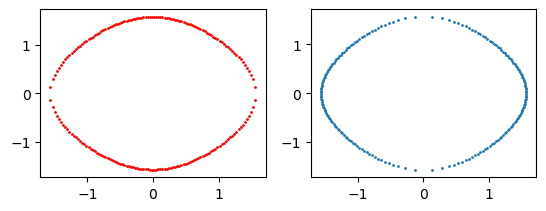

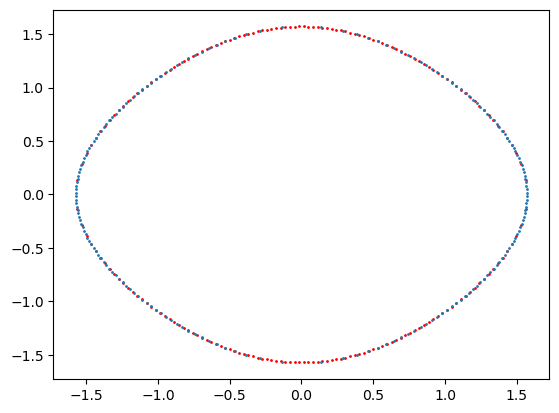

In [21]:
N = 196 # a nice root

def inverse(tx, visualize = False):

    res_x = np.zeros((2*N, 2))
    res_y = np.zeros((2*N, 2))


    for i, ang in enumerate(np.linspace(-3.14, 3.14, N)):
        y = solve(tx, ang)
        res_x[2*i, 0] = ang
        res_x[2*i, 1] = y

        res_y[2*i, 1] = ang
        res_y[2*i, 0] = y

        res_x[2*i+1, 0] = ang
        res_y[2*i+1, 1] = ang
        if y is not None:
            res_x[2*i+1, 1] = -y
            res_y[2*i+1, 0] = -y
        else:
            res_x[2*i+1, 1] = None
            res_y[2*i+1, 0] = None

    #remove the None values
    #res_x = res_x[~np.isnan(res_x).any(axis=1)]
    #res_y = res_y[~np.isnan(res_y).any(axis=1)]

    if visualize:
        plt.subplot(2, 2, 1)
        plt.scatter(res_x[:, 0], res_x[:, 1], s=1, c='r')
        plt.subplot(2, 2, 2)
        plt.scatter(res_y[:, 0], res_y[:, 1], s=1)
        plt.show()


        plt.scatter(res_x[:, 0], res_x[:, 1], s=1, c='r')
        plt.scatter(res_y[:, 0], res_y[:, 1], s=1)
        plt.show()


    point_cloud = np.concatenate((res_x, res_y))

    return point_cloud

point_cloud = inverse(1, visualize = True)





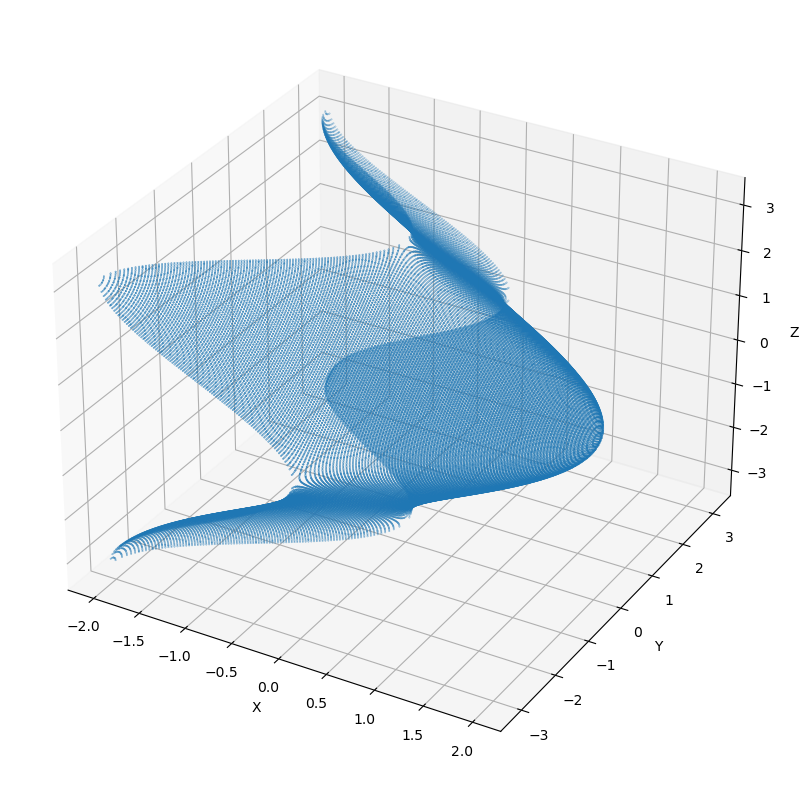

In [22]:
points = np.zeros((4*N*N, 3))

for i, tx in enumerate(np.linspace(-2.1, 2.1, N)):
    point_cloud = inverse(tx)
    points[i*4*N:(i+1)*4*N, 1:] = point_cloud
    points[i*4*N:(i+1)*4*N, 0] = tx

#3d plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

## Manifold identification

100%|██████████| 196/196 [00:22<00:00,  8.74it/s]


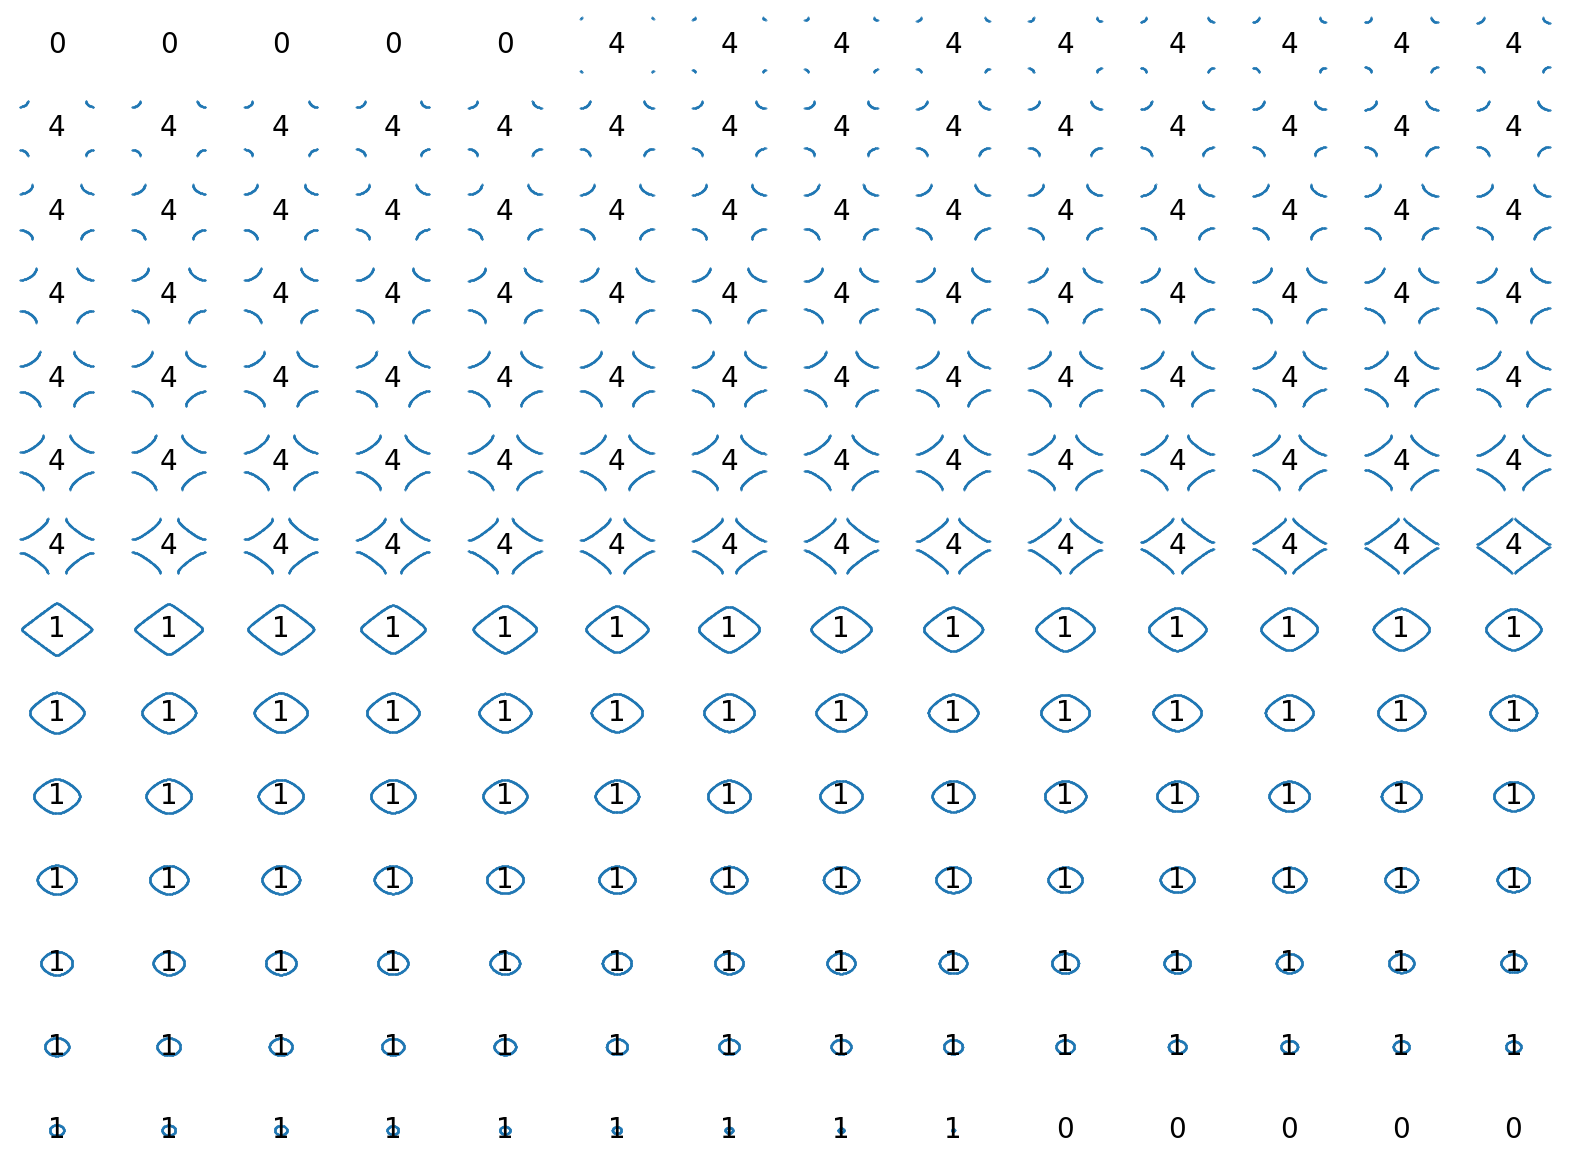

In [37]:
from sklearn.neighbors import KDTree

def Cluster(cloud, h = 0.1):

    cloud = cloud.copy()
    cloud = cloud[~np.isnan(cloud).any(axis=1)]

    if(cloud.shape[0] < 1):
        #return 0 and empty tree
        return 0, None, [], {}

    tree = KDTree(cloud)

    k = 0

    manifolds = []
    mapping = {}

    while len(cloud) > 0:
        cloud, manifold = Classify(cloud, tree, cloud[0], h)
        manifolds.append(manifold)

        for point in manifold:
            mapping[point] = k

        k += 1

    return k, tree, manifolds, mapping

def Classify(cloud, tree, point, h = 0.1):
    #classify all the points in the manifold of which point is a part

    queue = [point]
    explored = set([tuple(point)])

    while len(queue) > 0:

        point = queue.pop(0)
        cloud = cloud[~np.all(cloud == point, axis=1)]

        #find all the points in the neighborhood
        tree_res = tree.query_radius(point.reshape(1, -1), r = h, sort_results = True, return_distance = True) 

        indices = tree_res[0][0]
        indices = indices.astype(int)
        indices = indices[1:]

        for i in indices:
            p = np.asarray(tree.data[i])

            #check that p has not been explored yet and is not in queue
            if not tuple(p) in explored:
                queue.append(p)
                explored.add(tuple(p))

    return cloud, explored


h = 2*6.14/N

slices = []
manifolds_by_slice = []
trees = []
mappings = []

N_root = np.sqrt(N)
if N_root != int(N_root):
    N_root = int(N_root) + 1
N_root = int(N_root)

plt.subplots(N_root, N_root, figsize=(20, 15))
for i in tqdm.tqdm(range(N)):
    
    cloud = points[i*4*N:(i+1)*4*N, 1:]
    k, tree, manifolds, mapping = Cluster(cloud, h = h)
    slices.append([points[i*4*N, 0], k])
    trees.append(tree)
    manifolds_by_slice.append(manifolds)
    mappings.append(mapping)

    #print(k, end = ' ')

    #only show points on graph, no scale
    plt.subplot(N_root, N_root, i+1)
    
    plt.axis("off")   # turns off axes
    #both axis limits are set to -4 to 4
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.scatter(cloud[:, 0], cloud[:, 1], s = 0.1)
    #write the number of clusters in the centre
    plt.text(0, 0, str(k), fontsize = 20, horizontalalignment='center', verticalalignment='center')

plt.show()

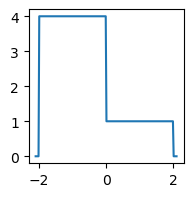

In [24]:
slices = np.array(slices)

#visualize number of manifolds by slices
plt.figure(figsize=(2, 2))
plt.plot(slices[:, 0], slices[:, 1])
plt.show()

## Manifold matching

In [53]:
def Match(manifolds_a, manifolds_b, tree_a, tree_b, mapping_a, mapping_b, h = 0.1):
    """
    Match two manifolds using the tree structure
    """

    omega = []

    for m in manifolds_a:
        manifold = list(m)
        omega_m = set([])
        
        for p in manifold:
            neighbours = tree_b.query_radius([p], r = h)[0]

            for n in neighbours:
                manifold_b = mapping_b[tuple(tree_b.data[n])]
                omega_m.add(manifold_b)

        omega.append(omega_m)
    return omega



In [54]:
def MatchById(id_a, id_b):
    return Match(manifolds_by_slice[id_a], manifolds_by_slice[id_b], trees[id_a], trees[id_b], mappings[id_a], mappings[id_b], h)


omega = MatchById(97, 98)

print(omega)


[{0}, {0}, {0}, {0}]
